Generating Points
- Units: mm
- Radius 16
- 75 degree curve
- 10 points (~2.37 mm apart)

Assumes curvature to the right, curve starts at (0,0)

In [1]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import math
import numpy as np


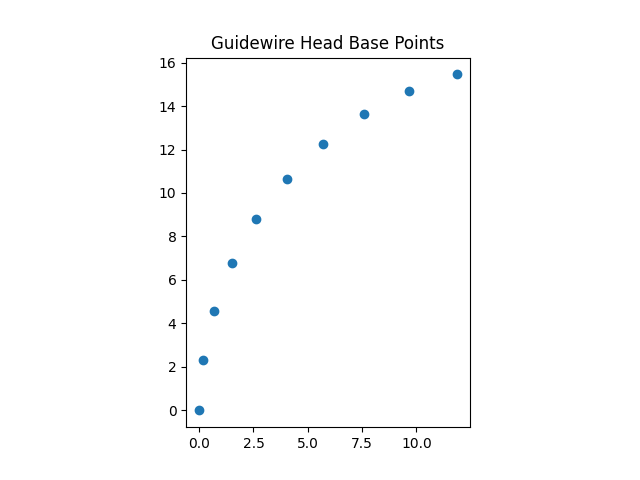

In [2]:
#input is in degrees,  internally converts to radians
def generate_base_pts(radius:float, angle_deg:int, num_points:int):
	
	ang_step = np.radians(angle_deg)/(num_points-1)

	x_ = np.array([])
	y_ = np.array([])
	for i in range (num_points):
		x_ = np.append(x_, radius- radius*np.cos(ang_step*i))
		y_ = np.append(y_, radius*np.sin(ang_step*i) )

	points = np.vstack((x_,y_,np.zeros(num_points))).T
	# print(points)

	return points

base_points = generate_base_pts(radius=16,angle_deg=75,num_points=10)
# print(base_points)

fig, ax = plt.subplots()

ax.scatter(base_points[:,0], base_points[:,1])
ax.set_aspect('equal', adjustable='box')
ax.set_title("Guidewire Head Base Points")

plt.show()

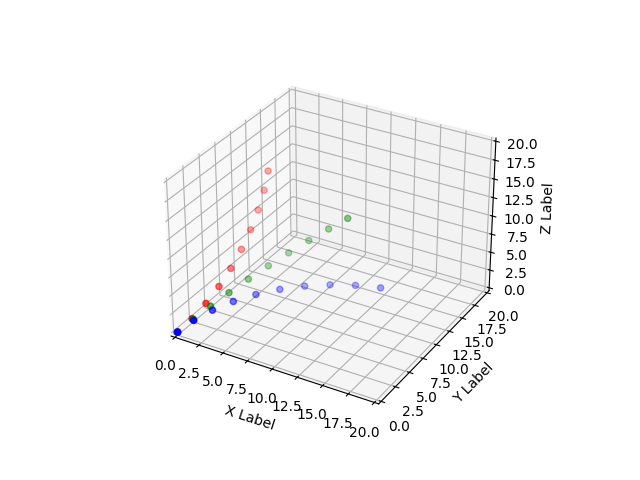

In [3]:
def rotate_y(angle_deg:int, points):
	angle = np.radians(angle_deg)
	rot_mat = np.array([ [ np.cos(angle), 0, np.sin(angle)],
					     [     0,         1,       0      ],
						 [-np.sin(angle), 0, np.cos(angle)] ])
	
	rotated_pts = np.empty_like(points)

	for i in range(points.shape[0]):
		ref_point = np.array([[points[i,0]],
						      [points[i,1]],
							  [      0    ] ] )
		
		temp_point = np.matmul(rot_mat, ref_point)
		rotated_pts[i,:] = temp_point.T

	# print(rotated_pts)
	return np.round(rotated_pts,3)



rotated = rotate_y(-90, base_points)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(rotated[:,0], rotated[:,1], rotated[:,2], color='r')
rotated = rotate_y(-45, base_points)
ax.scatter(rotated[:,0], rotated[:,1], rotated[:,2], color='g')
ax.scatter(base_points[:,0], base_points[:,1], base_points[:,2], color='b')

ax.set_xlim3d([0,20])
ax.set_ylim3d([0,20])
ax.set_zlim3d([0,20])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()


In [4]:
# for now, just truncates the z axis because we're projecting to the xy axis
def proj_to_2d(points):
	return points[:,:2]

print(np.round(proj_to_2d(rotated),3))


[[ 0.     0.   ]
 [ 0.119  2.319]
 [ 0.475  4.589]
 [ 1.06   6.762]
 [ 1.861  8.792]
 [ 2.862 10.637]
 [ 4.041 12.257]
 [ 5.374 13.618]
 [ 6.833 14.691]
 [ 8.386 15.455]]


In [5]:
PI = 3.14159265

# input arrays are 1d arrays. Assumes pt2 is in the middle
def get_angle(pt1, pt2, pt3):
	vec_a = pt3-pt2
	vec_b = pt1-pt2
	# print(vec_a)
	# print(vec_b)

	# numer = np.dot(vec_a,vec_b)
	# denom = np.linalg.norm(vec_a) * np.linalg.norm(vec_b)
	# return np.arccos(numer/denom)
	current_angle = np.arctan2(vec_b[1], vec_b[0])-np.arctan2(vec_a[1], vec_a[0])
	if(current_angle <0 ):
		current_angle = current_angle+ (2*PI)
	return current_angle




def get_dist(pt1, pt2):
	vec = (pt1-pt2)
	return np.linalg.norm(vec)


def generate_angle_dist(points):

	angles = np.array([])
	distances = np.array([])
	
	# print(points[0,:])
	# print(points[1,:].shape)
	# print(np.array([-1,0,0]).shape)
	# assumes that point "-1" is directly  below point 0
	angles = np.append(angles, get_angle(np.array([0,-1]), points[0,:], points[1,:]))
	distances = np.append(distances, get_dist(points[0,:], points[1,:]))
	
	for i in range(1,points.shape[0]-1):
		angles = np.append(angles, get_angle(points[i-1,:], points[i,:], points[i+1,:]))
		distances = np.append(distances, get_dist(points[i,:], points[i+1,:]))

	return angles, distances
	


# print("Base points:")
# print(proj_to_2d(base_points))
# print("----------------")
# angles, distances = generate_angle_dist(proj_to_2d(base_points))

# print("angles: " , angles)
# print("distances: " , distances)

# rotated = rotate_y(-90, base_points)

# angles, distances = generate_angle_dist(proj_to_2d(rotated))

# print("angles: " , angles)
# print("distances: " , distances)

# np.savetxt("Test Points.txt", (np.round(angles,3), np.round(distances,3)), fmt='%.3f', comments="Format: Angle \nNode Angles\nDistances")






In [6]:
#angle spacing between configurations, about major axis
angle_spacing = 10
# window of configurations, about major axis
total_sweep_ang = 350
# number of nodes in guidewire tip
num_points = 10

dist_configs = np.empty((int(90/angle_spacing),num_points-1))
angle_configs = np.empty((int(90/angle_spacing),num_points-1))
angle_labels = np.array([],dtype=int)



base_points = generate_base_pts(radius=16,angle_deg=75,num_points=num_points)


with open("endpoint_config_sparse.txt", "wb") as f:
	f.write(str("num nodes, num configs\n").encode())
	f.write(str(str(num_points) + "\n" + str(int(total_sweep_ang/angle_spacing)+1) + "\n").encode())
	for i in range(int(total_sweep_ang/angle_spacing)+1):
		temp_rotated = rotate_y(-angle_spacing*i, base_points)
		temp_angles, temp_distances = generate_angle_dist(proj_to_2d(temp_rotated))

		# writing angle
		f.write(str(angle_spacing*i).encode())
		f.write(b"\n")
		# node distances
		np.savetxt(f,[temp_distances], fmt='%.3f',delimiter=',')
		# node angles
		np.savetxt(f,[temp_angles], fmt='%.3f',delimiter=',')
		f.write(b"\n")

		# angle_labels = np.append(angle_labels,angle_spacing*i)
		# dist_configs[i,:] =  temp_distances
		# angle_configs[i,:] = temp_angles





: 